In [2]:
# Sparse GP Time Series Forecasting with GPyTorch and Inducing Points

import torch
import gpytorch
import numpy as np
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# ---------------------------------------
# 1. Prepare your data (replace with your actual data)
# ---------------------------------------

# For demonstration, generate small synthetic data
N_train, N_test, D = 10000, 2000, 5
np.random.seed(0)
X_train = np.random.randn(N_train, D)
y_train = np.sin(X_train[:, 0]) + 0.1 * np.random.randn(N_train)
X_test = np.random.randn(N_test, D)
y_test = np.sin(X_test[:, 0]) + 0.1 * np.random.randn(N_test)

# Convert to torch tensors
train_x = torch.tensor(X_train, dtype=torch.float32, device=device)
train_y = torch.tensor(y_train, dtype=torch.float32, device=device)
test_x = torch.tensor(X_test, dtype=torch.float32, device=device)
test_y = torch.tensor(y_test, dtype=torch.float32, device=device)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

(torch.Size([10000, 5]),
 torch.Size([10000]),
 torch.Size([2000, 5]),
 torch.Size([2000]))

In [5]:
# ---------------------------------------
# 2. Define Sparse GP Model
# ---------------------------------------
class SparseGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        # Variational Distribution & Strategy
        variational_dist = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(0)
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_dist, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [6]:

# Select M inducing points (e.g., uniformly from train)
M = 500
inducing_points = train_x[torch.randperm(train_x.size(0))[:M]]

model = SparseGPModel(inducing_points).to(device)
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_x.size(0)).to(device)


In [7]:
# ---------------------------------------
# 3. Train the Sparse GP
# ---------------------------------------
model.train()
likelihood.train()
optimizer = torch.optim.Adam(
    [
        {"params": model.parameters()},
        {"params": likelihood.parameters()},
    ],
    lr=0.01,
)

num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - ELBO Loss: {loss.item():.3f}")

Epoch 10/100 - ELBO Loss: 1.283
Epoch 20/100 - ELBO Loss: 1.113
Epoch 30/100 - ELBO Loss: 0.990
Epoch 40/100 - ELBO Loss: 0.894
Epoch 50/100 - ELBO Loss: 0.815
Epoch 60/100 - ELBO Loss: 0.744
Epoch 70/100 - ELBO Loss: 0.678
Epoch 80/100 - ELBO Loss: 0.616
Epoch 90/100 - ELBO Loss: 0.555
Epoch 100/100 - ELBO Loss: 0.495


In [8]:
# ---------------------------------------
# 4. Evaluate on Test Data
# ---------------------------------------
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(test_x))
    mean = preds.mean.cpu().numpy()
    var = preds.variance.cpu().numpy()

# Compute RMSE
rmse = root_mean_squared_error(test_y.cpu().numpy(), mean)
print(f"Test RMSE: {rmse:.3f}")

Test RMSE: 0.117


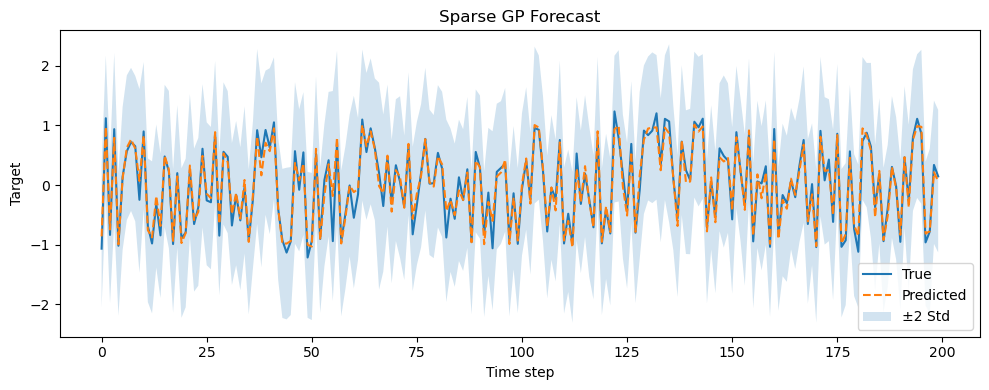

In [9]:

# ---------------------------------------
# 5. Plot Results (first 200 points)
# ---------------------------------------
plt.figure(figsize=(10, 4))
plt.plot(test_y.cpu().numpy()[:200], label="True")
plt.plot(mean[:200], label="Predicted", linestyle="--")
upper = mean + 2 * np.sqrt(var)
lower = mean - 2 * np.sqrt(var)
plt.fill_between(np.arange(200), lower[:200], upper[:200], alpha=0.2, label="±2 Std")
plt.legend()
plt.title("Sparse GP Forecast")
plt.xlabel("Time step")
plt.ylabel("Target")
plt.tight_layout()
plt.show()


### True Time Series Forecasting Example
- Multistep forecasting
- Forecasting horizon
- Lagged features
- Overlapping predictions

--> The above code shows the basic regression setting where y_i is modeled given x_i for all i independently without time information

In [31]:
def create_sliding_windows_multistep(data_series, history_length, forecast_horizon):
    """
    Creates sliding windows for multi-step time series forecasting.
    Args:
        data_series (np.array): The 1D time series data.
        history_length (int): Number of past time steps to use as input features.
        forecast_horizon (int): Number of future time steps to predict.
    Returns:
        X (np.array): Input features, shape (num_samples, history_length).
        Y (np.array): Target values, shape (num_samples, forecast_horizon).
    """
    X, Y = [], []
    for i in range(len(data_series) - history_length - forecast_horizon + 1):
        X.append(data_series[i : (i + history_length)])
        Y.append(
            data_series[(i + history_length) : (i + history_length + forecast_horizon)]
        )
    return np.array(X), np.array(Y)


In [46]:
# ---------------------------------------
# 1. Prepare your time series data
# ---------------------------------------
np.random.seed(0)
HISTORY_LENGTH = 24*7  # Use 24 hours of history
FORECAST_HORIZON = 24  # Predict 24 hours into the future
USE_TRAIN_FOR_TEST_HISTORY = False


# Generate synthetic time series data
N_total_points = 12000  # Total hourly data points
time_points = np.arange(N_total_points)
# y_series_full = (
#     np.sin(time_points * 0.1)
#     + 0.5 * np.sin(time_points * 0.01)
#     + 0.2 * np.random.randn(N_total_points)
# )
y_series_full = (
    # Seasonal components at different frequencies
    np.sin(time_points * 0.1)  # Fast oscillation
    + 0.5 * np.sin(time_points * 0.01)  # Slower oscillation
    # Non-linear trend component
    + 0.001
    * (time_points - N_total_points / 2) ** 2
    / N_total_points  # Quadratic trend
    # Time-varying noise (increases with time)
    + 0.1 * np.random.randn(N_total_points) * (1 + 0.5 * time_points / N_total_points)
)

# Split into train and test sets
N_train_series = 10000
y_series_train = y_series_full[:N_train_series]
y_series_test = y_series_full[N_train_series:]

# Create windows for training data
X_train_np, Y_train_np = create_sliding_windows_multistep(
    y_series_train, HISTORY_LENGTH, FORECAST_HORIZON
)

if USE_TRAIN_FOR_TEST_HISTORY:
    # For test data, we need history before the first prediction point
    # Take the last HISTORY_LENGTH points from training to use as history for first test prediction
    history_for_test = y_series_train[N_train_series - HISTORY_LENGTH : N_train_series]
    y_series_test = np.concatenate([history_for_test, y_series_test])

# Create windows for test data
X_test_np, Y_test_np = create_sliding_windows_multistep(
    y_series_test, HISTORY_LENGTH, FORECAST_HORIZON
)

# Print shapes for verification
print(f"X_train_np shape: {X_train_np.shape}, Y_train_np shape: {Y_train_np.shape}")
print(f"X_test_np shape: {X_test_np.shape}, Y_test_np shape: {Y_test_np.shape}")

# Convert to torch tensors
train_x = torch.tensor(X_train_np, dtype=torch.float32, device=device)
train_y = torch.tensor(Y_train_np, dtype=torch.float32, device=device)
test_x = torch.tensor(X_test_np, dtype=torch.float32, device=device)
test_y = torch.tensor(Y_test_np, dtype=torch.float32, device=device)

print(f"train_x shape: {train_x.shape}, train_y shape: {train_y.shape}")
print(f"test_x shape: {test_x.shape}, test_y shape: {test_y.shape}")

print(f"Training on device: {device}")


X_train_np shape: (9809, 168), Y_train_np shape: (9809, 24)
X_test_np shape: (1809, 168), Y_test_np shape: (1809, 24)
train_x shape: torch.Size([9809, 168]), train_y shape: torch.Size([9809, 24])
test_x shape: torch.Size([1809, 168]), test_y shape: torch.Size([1809, 24])
Training on device: cuda


In [47]:
# ---------------------------------------
# 2. Define Sparse GP Model for Multi-step Forecasting
# ---------------------------------------

M = 100  # Number of inducing points (reduce for faster demo with multiple models)
inducing_points_candidates = train_x[
    torch.randperm(train_x.size(0))[: max(M, train_x.size(0))]
]  # Ensure we don't exceed train_x size

models = []
likelihoods = []
mlls = []
optimizers = []

for h in range(FORECAST_HORIZON):
    # print(f"Initializing model for forecast step {h+1}/{FORECAST_HORIZON}")
    # Select M inducing points for each model (can be shared or different)
    # For simplicity, let's use the same candidate set and select from it,
    # or re-sample. Here, we re-sample for each.
    current_inducing_points = inducing_points_candidates[
        torch.randperm(inducing_points_candidates.size(0))[:M]
    ]

    model_h = SparseGPModel(current_inducing_points).to(device)
    likelihood_h = gpytorch.likelihoods.GaussianLikelihood().to(device)
    mll_h = gpytorch.mlls.VariationalELBO(
        likelihood_h, model_h, num_data=train_x.size(0)
    ).to(device)

    optimizer_h = torch.optim.Adam(
        [
            {"params": model_h.parameters()},
            {"params": likelihood_h.parameters()},
        ],
        lr=0.01,
    )

    models.append(model_h)
    likelihoods.append(likelihood_h)
    mlls.append(mll_h)
    optimizers.append(optimizer_h)

print(f"\nInitialized {len(models)} models.")



Initialized 24 models.


In [50]:
# ---------------------------------------
# 3. Train the Sparse GP models (one for each forecast horizon step)
# ---------------------------------------
num_epochs = 100  # Reduce epochs for faster demo with multiple models

for h in range(FORECAST_HORIZON):
    print(f"\nTraining model for forecast step {h+1}/{FORECAST_HORIZON}...")
    model = models[h]
    likelihood = likelihoods[h]
    mll = mlls[h]
    optimizer = optimizers[h]

    # Get the target for the current forecast step
    current_train_y = train_y[:, h]

    model.train()
    likelihood.train()

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(train_x)  # Input X is the same for all models
        loss = -mll(
            output, current_train_y
        )  # Target Y is specific to this horizon step
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"  Epoch {epoch+1}/{num_epochs} - ELBO Loss: {loss.item():.3f}")



Training model for forecast step 1/24...
  Epoch 1/100 - ELBO Loss: 1.040
  Epoch 10/100 - ELBO Loss: 1.013
  Epoch 20/100 - ELBO Loss: 0.981
  Epoch 30/100 - ELBO Loss: 0.950
  Epoch 40/100 - ELBO Loss: 0.916
  Epoch 50/100 - ELBO Loss: 0.883
  Epoch 60/100 - ELBO Loss: 0.848
  Epoch 70/100 - ELBO Loss: 0.812
  Epoch 80/100 - ELBO Loss: 0.775
  Epoch 90/100 - ELBO Loss: 0.738
  Epoch 100/100 - ELBO Loss: 0.700

Training model for forecast step 2/24...
  Epoch 1/100 - ELBO Loss: 1.041
  Epoch 10/100 - ELBO Loss: 1.012
  Epoch 20/100 - ELBO Loss: 0.981
  Epoch 30/100 - ELBO Loss: 0.949
  Epoch 40/100 - ELBO Loss: 0.916
  Epoch 50/100 - ELBO Loss: 0.882
  Epoch 60/100 - ELBO Loss: 0.848
  Epoch 70/100 - ELBO Loss: 0.812
  Epoch 80/100 - ELBO Loss: 0.776
  Epoch 90/100 - ELBO Loss: 0.739
  Epoch 100/100 - ELBO Loss: 0.701

Training model for forecast step 3/24...
  Epoch 1/100 - ELBO Loss: 1.037
  Epoch 10/100 - ELBO Loss: 1.009
  Epoch 20/100 - ELBO Loss: 0.977
  Epoch 30/100 - ELBO Los


Predicted means shape: (1809, 24)
True test Y shape: torch.Size([1809, 24])
Average Test RMSE across horizon: 0.422


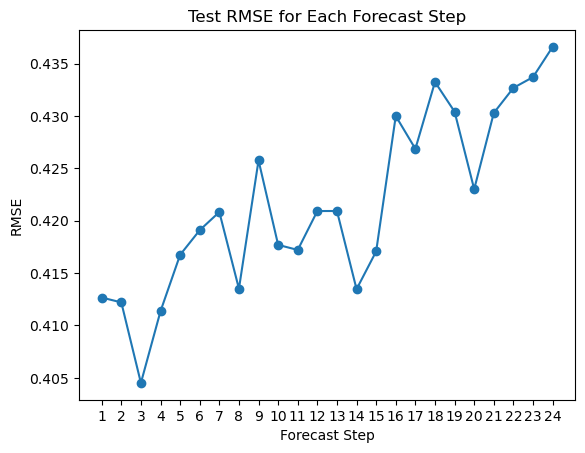

In [51]:
# ---------------------------------------
# 4. Evaluate on Test Data
# ---------------------------------------
all_means_test = []
all_vars_test = []

for h in range(FORECAST_HORIZON):
    # print(f"Evaluating model for forecast step {h+1}/{FORECAST_HORIZON}...")
    model = models[h]
    likelihood = likelihoods[h]

    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # test_x are the lagged features from the test set
        preds_h = likelihood(model(test_x))
        mean_h = preds_h.mean.cpu().numpy()
        var_h = preds_h.variance.cpu().numpy()

    all_means_test.append(mean_h)
    all_vars_test.append(var_h)

# Stack predictions: results in shape (num_test_samples, FORECAST_HORIZON)
predicted_means_test = np.stack(all_means_test, axis=1)
predicted_vars_test = np.stack(all_vars_test, axis=1)

print(f"\nPredicted means shape: {predicted_means_test.shape}")  # Shape (# samples, H)
print(f"True test Y shape: {test_y.shape}")

# Compute RMSE for each forecast step
rmses_per_step = []
for h in range(FORECAST_HORIZON):
    true_h = test_y[:, h].cpu().numpy()
    pred_h = predicted_means_test[:, h]
    rmse_h = root_mean_squared_error(true_h, pred_h)
    rmses_per_step.append(rmse_h)
    # print(f"Test RMSE for step {h+1}: {rmse_h:.3f}")

print(f"Average Test RMSE across horizon: {np.mean(rmses_per_step):.3f}")

plt.plot(
    np.arange(1, FORECAST_HORIZON + 1), rmses_per_step, marker="o", label="RMSE"
)
plt.xticks(np.arange(1, FORECAST_HORIZON + 1))
plt.xlabel("Forecast Step")
plt.ylabel("RMSE")
plt.title("Test RMSE for Each Forecast Step")
plt.show()


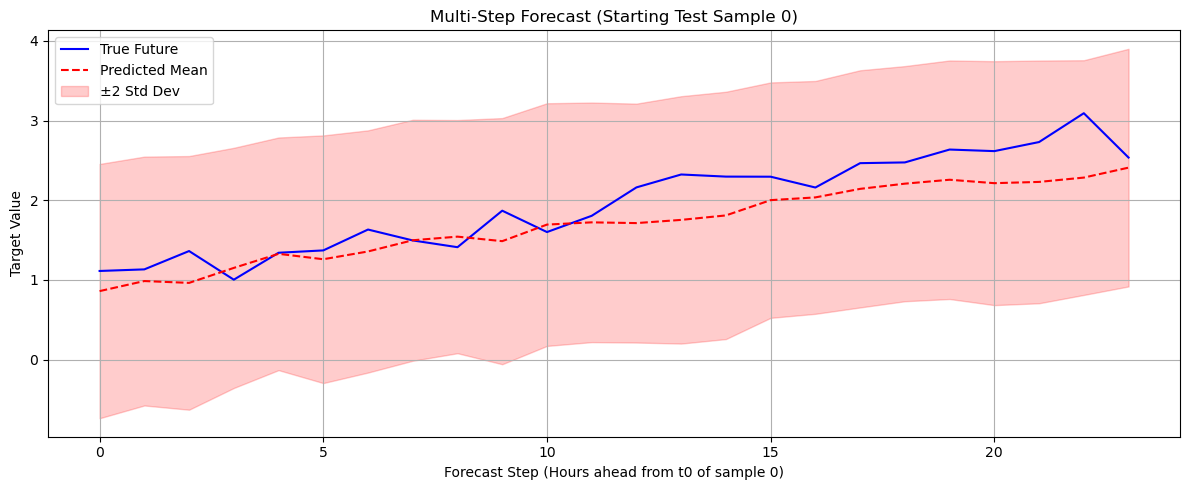

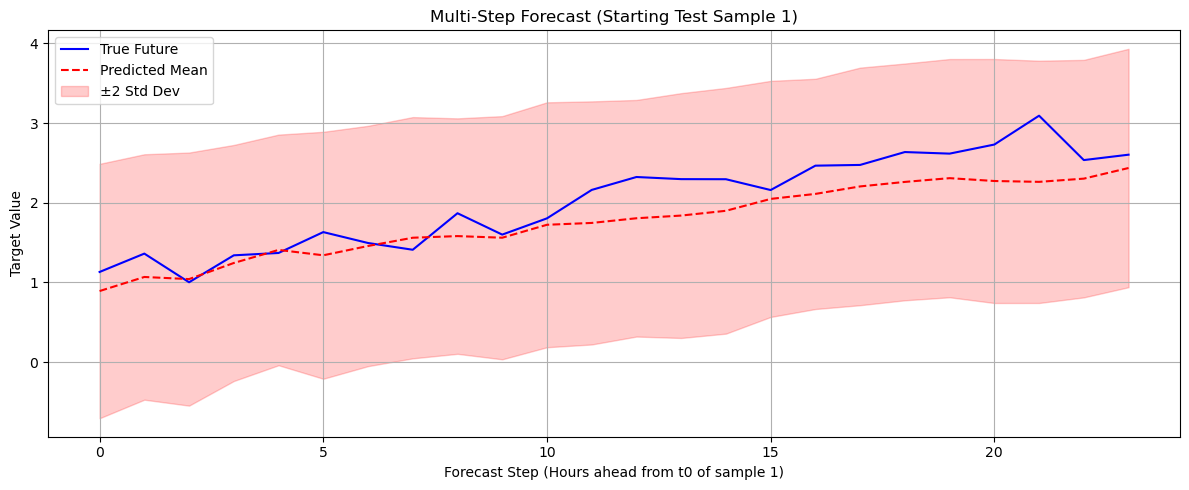

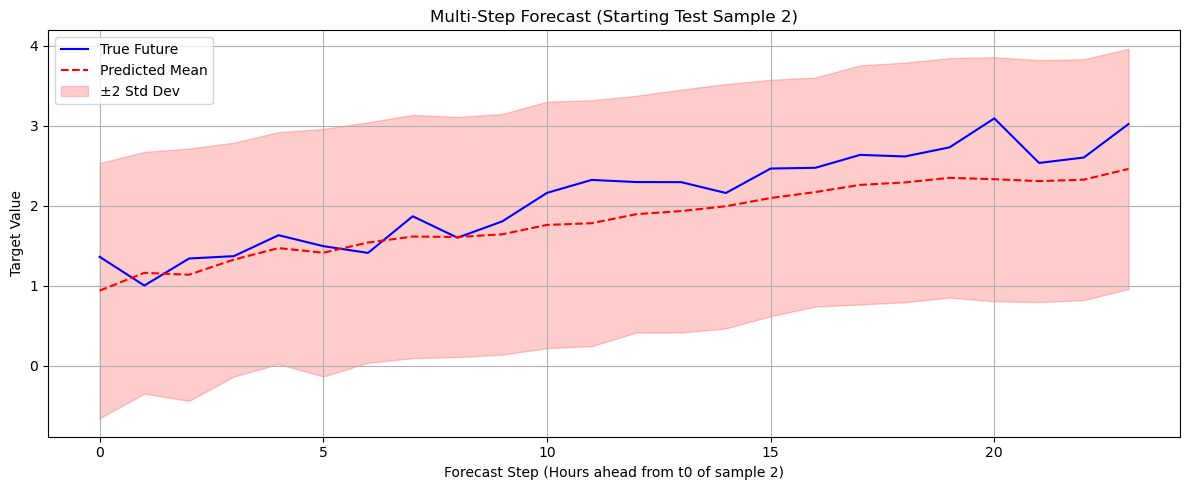

In [52]:
# ---------------------------------------
# 5. Plot Results for a few forecast sequences
# ---------------------------------------

num_sequences_to_plot = 3
num_sequences_to_plot = min(num_sequences_to_plot, test_x.size(0))


for i in range(num_sequences_to_plot):
    plt.figure(figsize=(12, 5))

    # Define the x-axis for the forecast horizon
    forecast_steps_axis = np.arange(FORECAST_HORIZON)

    # True future values for this sequence
    true_future_sequence = test_y[i, :].cpu().numpy()

    # Predicted future values for this sequence
    predicted_future_sequence = predicted_means_test[i, :]
    predicted_future_vars = predicted_vars_test[i, :]

    plt.plot(forecast_steps_axis, true_future_sequence, "b-", label="True Future")
    plt.plot(
        forecast_steps_axis, predicted_future_sequence, "r--", label="Predicted Mean"
    )

    upper_bound = predicted_future_sequence + 2 * np.sqrt(predicted_future_vars)
    lower_bound = predicted_future_sequence - 2 * np.sqrt(predicted_future_vars)
    plt.fill_between(
        forecast_steps_axis,
        lower_bound,
        upper_bound,
        color="red",
        alpha=0.2,
        label="±2 Std Dev",
    )

    # To show context: the history that led to this forecast
    # history_for_this_forecast = test_x[i, :].numpy()
    # history_axis = np.arange(-HISTORY_LENGTH, 0)
    # plt.plot(history_axis, history_for_this_forecast, 'g:', label="Input History")

    plt.title(f"Multi-Step Forecast (Starting Test Sample {i})")
    plt.xlabel(f"Forecast Step (Hours ahead from t0 of sample {i})")
    plt.ylabel("Target Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# How to handle overlapping predictions:
# The above plots individual, distinct forecast sequences. Each plot starts from a
# specific point in the test set (test_x[i]) and shows the 24-hour forecast from that point.
# These sequences are "overlapping" in the sense that the input window for test_x[i+1]
# shares most of its data with the input window for test_x[i].
# We are NOT trying to stitch together all t+1 predictions, then all t+2 predictions etc.
# from different starting points into one continuous line, as that can be misleading
# and doesn't represent how a single forecast sequence is generated.
# The evaluation (RMSE per step) correctly assesses the quality at each horizon distance.


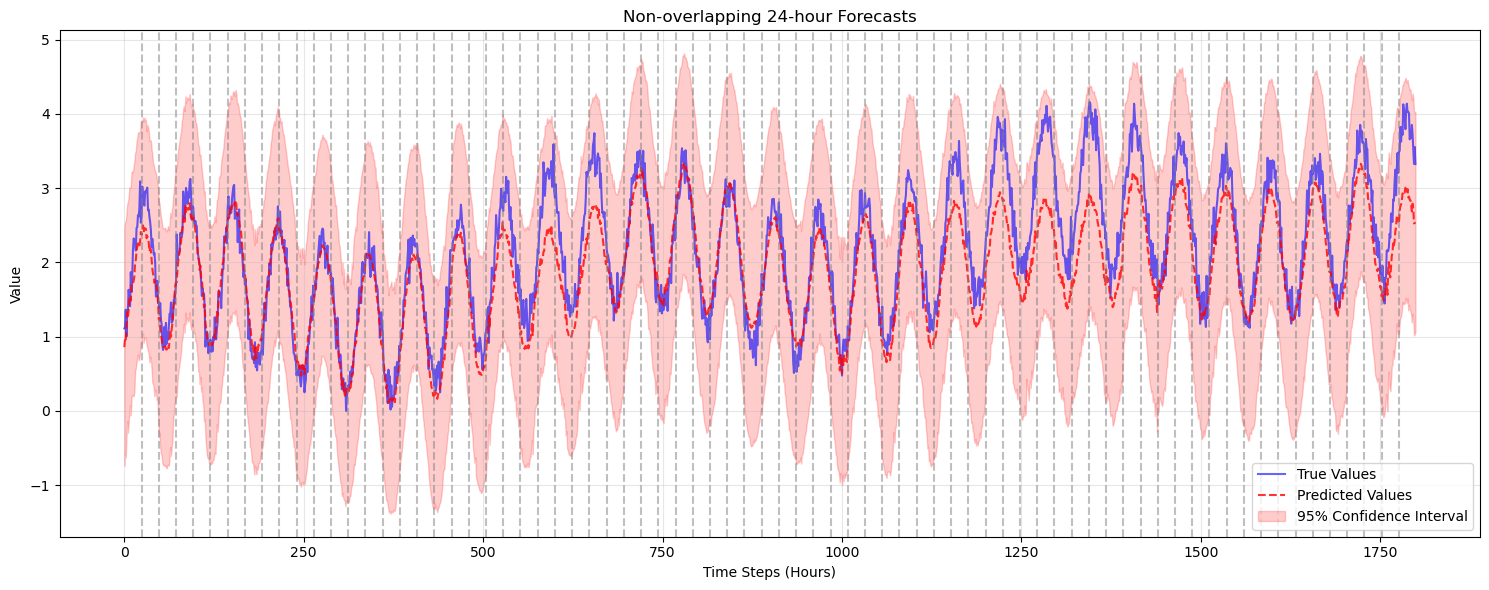

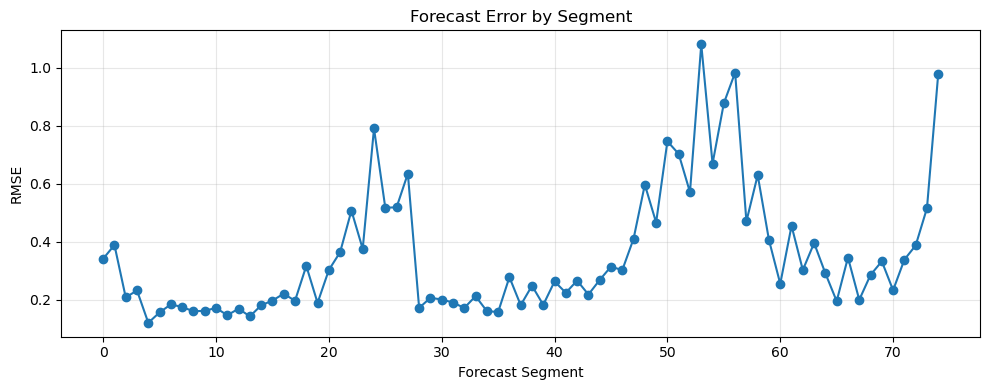

In [53]:
# ---------------------------------------
# 2. Plot along the entire test set
# ---------------------------------------

# Calculate how many non-overlapping 24-hour segments we can have
number_non_overlapping_test_samples = len(test_y) // FORECAST_HORIZON

# Create time axis for the entire plot
time_axis = np.arange(number_non_overlapping_test_samples * FORECAST_HORIZON)

plt.figure(figsize=(15, 6))

# Extract actual values for the same time points we'll be forecasting
true_values = []
predicted_values = []
confidence_lower = []
confidence_upper = []

# For each non-overlapping segment
for i in range(number_non_overlapping_test_samples):
    # Get the index in the test data
    idx = i * FORECAST_HORIZON
    
    # Extract true values for this segment
    segment_true = test_y[idx].cpu().numpy()
    true_values.extend(segment_true)
    
    # Extract predictions for this segment
    segment_predicted = predicted_means_test[idx]
    predicted_values.extend(segment_predicted)
    
    # Calculate confidence intervals
    segment_vars = predicted_vars_test[idx]
    segment_lower = segment_predicted - 2 * np.sqrt(segment_vars)
    segment_upper = segment_predicted + 2 * np.sqrt(segment_vars)
    confidence_lower.extend(segment_lower)
    confidence_upper.extend(segment_upper)

# Convert to numpy arrays
true_values = np.array(true_values)
predicted_values = np.array(predicted_values)
confidence_lower = np.array(confidence_lower)
confidence_upper = np.array(confidence_upper)

# Plot true values
plt.plot(time_axis, true_values, 'b-', label='True Values', alpha=0.6)

# Plot predicted values
plt.plot(time_axis, predicted_values, 'r--', label='Predicted Values', alpha=0.8)

# Plot confidence intervals
plt.fill_between(time_axis, confidence_lower, confidence_upper, color='red', alpha=0.2, label='95% Confidence Interval')

# Add vertical lines to separate the 24-hour segments
for i in range(1, number_non_overlapping_test_samples):
    plt.axvline(x=i*FORECAST_HORIZON, color='gray', linestyle='--', alpha=0.5)

plt.xlabel('Time Steps (Hours)')
plt.ylabel('Value')
plt.title('Non-overlapping 24-hour Forecasts')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: Display forecast metrics for each segment
segment_rmses = []
for i in range(number_non_overlapping_test_samples):
    idx = i * FORECAST_HORIZON
    segment_true = test_y[idx].cpu().numpy()
    segment_predicted = predicted_means_test[idx]
    segment_rmse = root_mean_squared_error(segment_true, segment_predicted)
    segment_rmses.append(segment_rmse)

plt.figure(figsize=(10, 4))
plt.plot(np.arange(number_non_overlapping_test_samples), segment_rmses, marker='o')
plt.xlabel('Forecast Segment')
plt.ylabel('RMSE')
plt.title('Forecast Error by Segment')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

